In [1]:
from pytesseract import *
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# credit to: https://gist.github.com/mweibel/bd2d6c2271e42ed97b97

#image processing resources
from skimage.io import imread, imshow
from skimage.filters import gaussian, threshold_otsu
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line, rotate

#testing 
import numpy as np
import os

#deskewing function

def deskew_angle(image):
    #image = imread(filename, as_grey=True)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #threshold to get rid of extraneous noise
    thresh = threshold_otsu(image)
    normalize = image > thresh

    # gaussian blur
    blur = gaussian(normalize, 3)

    # canny edges in scikit-image
    edges = canny(blur)

    # hough lines
    hough_lines = probabilistic_hough_line(edges)

    # hough lines returns a list of points, in the form ((x1, y1), (x2, y2))
    # representing line segments. the first step is to calculate the slopes of
    # these lines from their paired point values
    slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else 0 for (x1,y1), (x2, y2) in hough_lines]

    # it just so happens that this slope is also y where y = tan(theta), the angle
    # in a circle by which the line is offset
    rad_angles = [np.arctan(x) for x in slopes]

    # and we change to degrees for the rotation
    deg_angles = [np.degrees(x) for x in rad_angles]

    # which of these degree values is most common?
    histo = np.histogram(deg_angles, bins=180)
    
    # correcting for 'sideways' alignments
    rotation_number = histo[1][np.argmax(histo[0])]

    if rotation_number > 45:
        rotation_number = -(90-rotation_number)
    elif rotation_number < -45:
        rotation_number = 90 - abs(rotation_number)

    return rotation_number


def deskew(image):
    rotation_angle = deskew_angle(image)
    rotation_matrix = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), rotation_angle, 1)
    image_rotation = cv2.warpAffine(image, rotation_matrix, (image.shape[1],image.shape[0]))

    return image_rotation

In [5]:
def get_prices(df):
    ############### prices --> df1  ##################
    # assume all float numbers are prices, select them out
    tmp = df.text.apply(lambda x: bool(re.match(r"\d+\.\d{2}", x)), 1)
    df1 = df[tmp].reset_index()
    # now the new dataframe "df1" has less rows, we still want to keep their indices in "df", the one from tesseract
    df1 = df1.rename(columns={'index': 'old_index'})   

    # Select only valid prices:
    # What the code does here is to check there the x.x number comes together with another x.x number
    # because it is very likely the prices we are interested don't come alone, in contrast to the prices 
    # in description
    def check_neighbor_exist(i):
        """ return whether there is another float number next to it, this can be done by using old_index """
        cur_old_index = df1.loc[i, "old_index"]
        
        # the "old_index" of the previous x.x number 
        prev_old_index = df1.loc[i - 1, "old_index"] if i != 0 else -2 
        # here -2 can be any negative number, just to make sure "prev, suc" wouldn't be 1 when they shouldn't be
        prev = cur_old_index - prev_old_index # check whether their "old_index" differ only by 1
        
        #  the "old_index" of the next x.x number 
        suc_old_index = df1.loc[i + 1, "old_index"] if i != len(df1) - 1 else -2
        suc = suc_old_index - cur_old_index # check whether their "old_index" differ only by 1
        if prev == 1 or suc == 1:
            return True
        else:
            return False
    
    valid_ids = [i for i in df1.index if check_neighbor_exist(i)] # filter out prices in description
    df1 = df1.iloc[valid_ids]
    df1['begin'] = 0
    
    return df1



def get_No(df):
    ################   wine No. --> df2  ###################
    # select out all wine No., assuming they are always the first word on the same line, or "word_num" = 1
    check = df.text.apply(lambda x: bool(re.match(r"[0-9]+$", x)), 1)
    df2 = df[check].reset_index()
    df2 = df2.rename(columns={'index': 'old_index'})

    def check_first_word(i):
        """ return whether it is the first word on the same line """
        j = i + 1
        while j < len(df) and df.loc[i,'line_num'] == df.loc[j,'line_num']:
            if len(df.loc[j,'text']) > 0 and 'a' <= df.loc[j,'text'][0] <= 'z':
                return False
            j += 1
        return True
        #return df2.loc[i, "word_num"] == 1

    valid_ids = [i for i in df2.index if check_first_word(i)]
    df2 = df2.iloc[valid_ids]
    df2['begin'] = 1
    
    return df2





def img_df3(img):
    # call tesseract function
    out = image_to_data(img)

    with open('tmp', "w") as f:
        f.write(out)
    # df = pd.read_csv('tmp.csv', sep=',', engine="python")
    df = pd.DataFrame.from_csv('tmp', sep='\t')

    # if the text is Null/None/Nan, drop the row
    df = df[df.text.notnull()].reset_index(drop=True)
    os.remove('tmp')

    
    df1 = get_prices(df)
    df2 = get_No(df)

    ################  concatenate --> df3  ##################
    df3 = pd.concat([df1, df2]).sort_values('old_index')

    return df, df3

In [10]:
def table_reader(filename):
    #filename = os.path.join(os.getcwd(), '../sample1/UCD_Lehmann_0922.jpg')
    
    ### (1) Read the image:
    img = cv2.imread(filename)
    # img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img2 = cv2.Laplacian(img, cv2.CV_64F)
    
    
    img = deskew(img) 
    
    
    ### (2) Find the box we want to crop and do the cropping
    df, df3 = img_df3(img)
    top, bottom = max(df3.top.min() - 100, 0), min(df3.top.max() + 100, 6000)
    #left, right = max(df3.left.min() - 100, 0), df3.left.max() + 100
    # print("top, bottom", top, bottom)
    try:
        df, df3 = img_df3(img[top:bottom])
    except:
        pass
    
    
    ### (3) add wine info. to Pandas DataFrame
    res = []  # create an empty array, then we will append wine info to it as we iterate over all the items
    for i in range(len(df3) - 1):
        # for i in range(5):
        if df3.iloc[i].begin == 1 and (i + 1 == len(df3) or df3.iloc[i + 1].begin == 0):
            tmp = []

            # add wine No.:
            # it should be an integer number
            tmp.append(df3.iloc[i].text)
            start = i

            # add prices:
            # they takes the form x.x
            prices = []
            end = i + 1
            while end < len(df3) - 1 and df3.iloc[end].begin == 0:
                prices.append(df3.iloc[end].text)
                end += 1
            # print("end at:", df3.iloc[end-1]['old_index'])

            # add name:
            s = ''
            for k in range(df3.iloc[i]['old_index'] + 1, df3.iloc[i + 1]['old_index']):
                # print(k, df.iloc[k].text)
                s += ' ' + df.iloc[k].text
            s = s.rstrip(' .')
            tmp.append(s)

            # add description:
            s = ''
            for k in range(df3.iloc[end - 1]['old_index'] + 1, df3.iloc[end]['old_index']):
                s += ' ' + df.iloc[k].text
            s = s.rstrip(' .')
            tmp.append(s)
            
            # finally add them all to the list that we will use to create pandas dataframe
            res.append(tmp + prices)
    
    # find the maximum length, it varies from images to images because the number of prices might be different
    L = max([len(s) for s in res])
    for s in res:
        s += [''] * (L - len(s))
    
    # create the data frame and save it to .csv file
    res_df = pd.DataFrame(np.array(res),columns=["No.", "Name", "Description"] + ["Prices" + str(i+1) for i in range(L-3)])
    res_df.to_csv('./' + filename[-20:-3] + "csv")
    
    return res_df

## Try on Single Image

In [161]:
filename = os.path.join(os.getcwd(), '../sample1/UCD_Lehmann_0059.jpg')
img = cv2.imread(filename)

In [149]:
deskewed_img = deskew(img)

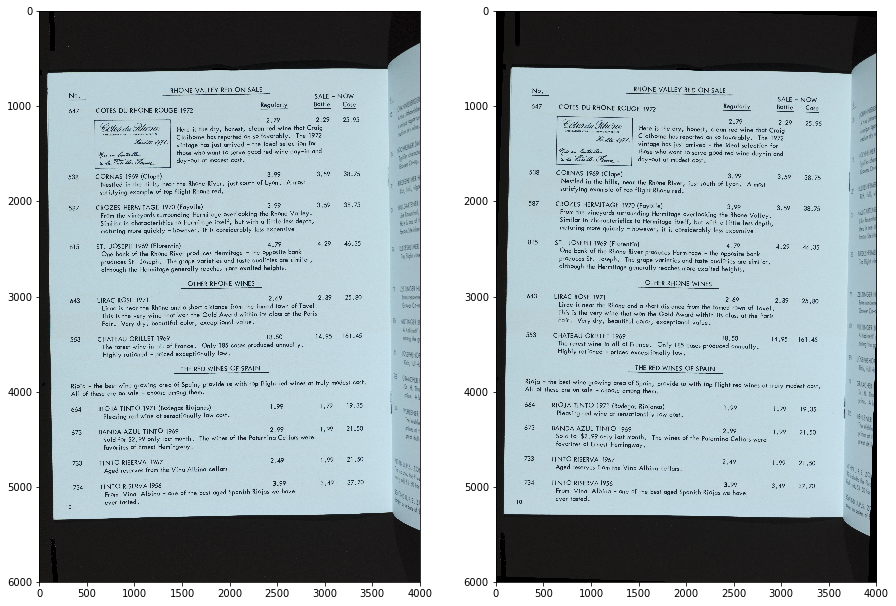

In [152]:
plt.figure(figsize=(15,12))
#fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(deskewed_img)


In [11]:
filename = os.path.join(os.getcwd(), '../sample1/UCD_Lehmann_0427.jpg')
#filename = os.path.join(os.getcwd(), 'no_noise_UCD_Lehmann_0347.jpg')
df = table_reader(filename)
df.head()

,No.,Name,Description,Prices1,Prices2,Prices3,Prices4,Prices5,Prices6,Prices7,Prices8,Prices9,Prices10,Prices11,Prices12,Prices13
0,1972,"-——————1Regu'°"" 3°1er C°Se","Here is the dry, hOnest, clean red wine that ...",2.79,2.29,25.95,,,,,,,,,,
1,1969,(Clape),"Nestled in the hills, near the RhOne River, j...",3.99,3.59,38.75,,,,,,,,,,
2,1970,(Foyolle),FrOm the vineyards surr0unding Hermitage over...,3.99,3.59,38.75,,,,,,,,,,
3,1969,(Florentin),One bank 0f the RhOne River produces Hermitag...,4.79,4.29,46.35,,,,,,,,,,
4,1971,,Lirac is near the Rhone and a short distance ...,2.69,2.39,25.80,,,,,,,,,,


## Try on Multiple/All Images

In [ ]:
path = os.path.join('../sample1','')
imgs = [img for img in os.listdir(path) if img.endswith('.jpg')]
for i, img in enumerate(imgs):
    print()
    print("Image No. %d: %s ......" %(i,img))
    file_path = os.path.join(os.getcwd(), '../sample1/',img)
    try:
        df = table_reader(file_path)
        print(df.head())
    except:
        print("doesn't work for ", img)
        continue

In [ ]:
path = os.path.join('../sample1','')
imgs = [img for img in os.listdir(path) if img.endswith('.jpg')]
for i, img in enumerate(imgs):
    print()
    print("Image No. %d: %s ......" %(i,img))
    file_path = os.path.join(os.getcwd(), '../sample1/',img)
    try:
        df = table_reader(file_path)
        print(df.head())
    except:
        print("doesn't work for ", img)
        continue


Image No. 0: UCD_Lehmann_0006.jpg ......
    No.                                            Name  \
0  5028   CHATEAU PICHON LONGUEVILLE LALANDE [Pauillac]   
1  5081           CHATEAU COS D’ESTOURNEL (St. Estephe)   
2  5078          CHATEAU LEOVILLE LASCASES (St. Iulien]   
3  5088       CARRUADES DE LAFITE ROTHSCHILD (Pauillac)   
4   832          CHATEAU LA MISSION HAUT BRION (Graves)   

                                         Description Prices1 Prices2  
0   Our comparative tastings indicate Clearly tha...    6.99   75.50  
1                                                       7.95   85.85  
2                                                       7.99   86.30  
3                                                       8.95   96.65  
4                                                      10.95  118.20  

Image No. 1: UCD_Lehmann_0007.jpg ......
doesn't work for  UCD_Lehmann_0007.jpg

Image No. 2: UCD_Lehmann_0015.jpg ......
   No.                                       Name  \
0

doesn't work for  UCD_Lehmann_0435.jpg

Image No. 18: UCD_Lehmann_0525.jpg ......
doesn't work for  UCD_Lehmann_0525.jpg

Image No. 19: UCD_Lehmann_0531.jpg ......
   No.   Name Description Prices1 Prices2
0  166   1972                4.99   59.88
1  348   1970                9.95  119.40
2  182   1966                8.99        

Image No. 20: UCD_Lehmann_0575.jpg ......
doesn't work for  UCD_Lehmann_0575.jpg

Image No. 21: UCD_Lehmann_0664.jpg ......
   No.                      Name  \
0  213            CHATEAU DE PEZ   
1  244      CHATEAU CLOS FOURTET   
2  195            CHATEAU GLORIA   
3  132            CHATEAU FIGEAC   
4  115   CHATEAU COS D’ESTOURNEL   

                                         Description Prices1 Prices2  
0         At this price, it is a ‘find.’ St. Estephe    3.99   43.10  
1   Here is Grand Cru St. Emilion rich in bottle ...    4.99   53.90  
2                              ’62 Gloria is a glory    4.99   53.90  
3   The orchestration of a great St. Emili

#### Try to find images that have truth result

In [36]:
truth = set(['UCD_Lehmann_' + re.findall(r'\d{4}',f)[0] + '.jpg' for f in os.listdir('../Truth1')])
sample = os.listdir('../Sample5')
imgs = [f for f in sample if f in truth]
imgs

['UCD_Lehmann_3336.jpg']